## Imports & Definitions

In [59]:
import numpy as np

import re
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

df_raw = pl.read_csv('./data/rent_dataset.csv')

df_raw = df_raw.with_columns(pl.col('Posted On').str.to_datetime('%Y-%m-%d'))

In [60]:
df_raw

Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
datetime[μs],i64,i64,i64,str,str,str,str,str,str,i64,str
2022-05-18 00:00:00,2,10000,1100,"""Ground out of 2""","""Super Area""","""Bandel""","""Kolkata""","""Unfurnished""","""Bachelors/Family""",2,"""Contact Owner"""
2022-05-13 00:00:00,2,20000,800,"""1 out of 3""","""Super Area""","""Phool Bagan, Kankurgachi""","""Kolkata""","""Semi-Furnished""","""Bachelors/Family""",1,"""Contact Owner"""
2022-05-16 00:00:00,2,17000,1000,"""1 out of 3""","""Super Area""","""Salt Lake City Sector 2""","""Kolkata""","""Semi-Furnished""","""Bachelors/Family""",1,"""Contact Owner"""
2022-07-04 00:00:00,2,10000,800,"""1 out of 2""","""Super Area""","""Dumdum Park""","""Kolkata""","""Unfurnished""","""Bachelors/Family""",1,"""Contact Owner"""
2022-05-09 00:00:00,2,7500,850,"""1 out of 2""","""Carpet Area""","""South Dum Dum""","""Kolkata""","""Unfurnished""","""Bachelors""",1,"""Contact Owner"""
…,…,…,…,…,…,…,…,…,…,…,…
2022-05-18 00:00:00,2,15000,1000,"""3 out of 5""","""Carpet Area""","""Bandam Kommu""","""Hyderabad""","""Semi-Furnished""","""Bachelors/Family""",2,"""Contact Owner"""
2022-05-15 00:00:00,3,29000,2000,"""1 out of 4""","""Super Area""","""Manikonda, Hyderabad""","""Hyderabad""","""Semi-Furnished""","""Bachelors/Family""",3,"""Contact Owner"""
2022-07-10 00:00:00,3,35000,1750,"""3 out of 5""","""Carpet Area""","""Himayath Nagar, NH 7""","""Hyderabad""","""Semi-Furnished""","""Bachelors/Family""",3,"""Contact Agent"""


In [61]:
def categorize_floor(floor: str) -> str:
    """Assing a category to the floor based on its description."""

    floor_lower = floor.lower()
    if 'basement' in floor_lower or 'ground' in floor_lower:
        return 'Ground Floor/Basement'

    match = re.search(r'(\d+)\s*out\s*of\s*(\d+)', floor_lower)
    if match:
        current_floor = int(match.group(1))
        total_floors = int(match.group(2))

        if current_floor / total_floors <= 0.5:
            return 'Lower Floor'
        else:
            return 'Upper Floor'

    match_single = re.search(r'(\d+)', floor_lower)
    if match_single:
        current_floor = int(match_single.group(1))
        if current_floor <= 10:
            return 'Lower Floor'
        else:
            return 'Upper Floor'

    return 'Unknown/Other'


def numerical_cols_plot(df: pl.DataFrame, numerical_cols: list[str]) -> None:
    """Plot histograms and boxplots for numerical columns."""

    for col in numerical_cols:
        data = df.select(pl.col(col)).to_series()
        target = df.select(pl.col('Rent')).to_series()

        # Histogram + Boxplot
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(data, kde=True, ax=axes[0])
        axes[0].set_title(f'Distribution of {col}')
        sns.boxplot(x=data, ax=axes[1])
        axes[1].set_title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()

        # Scatter plot vs Rent
        plt.figure(figsize=(6, 4))
        sns.regplot(x=data, y=target, scatter_kws={'alpha': 0.3})
        plt.title(f'{'Rent'} vs {col}')
        plt.xlabel(col)
        plt.ylabel('Rent')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Pearson correlation
        corr = df.select(pl.corr(col, 'Rent')).item()
        print(f' Correlation between {col} and Rent: {corr:.2f}')


def old_categorical_cols_plot(df: pl.DataFrame, categorical_cols: list[str]) -> None:
    """Plot categorical columns with their frequency distribution."""
    for col in categorical_cols:
        counts = df.group_by(col).len().sort('len', descending=True)
        categories = counts.select(col).to_series().to_list()
        values = counts.select('len').to_series().to_list()

        print(f'\nFrequency of {col}:')
        print(counts)

        plt.figure(figsize=(8, 4))
        sns.barplot(x=categories, y=values)
        plt.title(f'Distribution of {col}')
        plt.show()


def categorical_cols_plot(df: pl.DataFrame, categorical_cols: list[str]) -> None:
    """For each categorical column, show a table of frequency and average rent, and plot both on one chart."""

    for col in categorical_cols:
        # Aggregate frequency and average rent
        summary_df = (
            df.group_by(col)
              .agg([
                  pl.len().alias('Frequency'),
                  pl.col('Rent').mean().alias('Avg_rent')
              ])
              .sort('Frequency', descending=True)
        )

        print(f'\n Summary for {col}:')
        print(summary_df)

        # Extract for plotting
        summary_df.sort(col, descending=True)
        categories = summary_df.select(col).to_series().to_list()
        freqs = summary_df.select('Frequency').to_series().to_list()
        avgs = summary_df.select('Avg_rent').to_series().to_list()

        # Dual-axis plot: Bar for frequency, Line for average rent
        fig, ax1 = plt.subplots(figsize=(10, 5))

        ax2 = ax1.twinx()
        sns.barplot(x=categories, y=freqs, ax=ax1, color='skyblue')

        positions = np.arange(len(categories))
        sns.lineplot(x=positions, y=avgs, ax=ax2, color='red', marker='o')

        ax1.set_ylabel('Frequency', color='skyblue')
        ax2.set_ylabel(f'Avg rent', color='red')
        ax1.set_title(f'{col}: Frequency and Avg rent')
        ax1.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()


def bhk_vs_bathrooms(df: pl.DataFrame) -> pl.DataFrame:
    df_agg = (
        df.group_by(['BHK', 'Bathroom'])
        .len()
        .rename({'len': 'Frequency'})
        .sort('Frequency', descending=True)
    )

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=df_agg.select('BHK').to_series().to_list(),
        y=df_agg.select('Bathroom').to_series().to_list(),
        size=df_agg.select('Frequency').to_series().to_list(),
        sizes=(50, 500),
        legend=False,
        alpha=0.6,
    )
    plt.title('BHK vs. Bathrooms (Dot Size = Frequency)')
    plt.xlabel('BHK')
    plt.ylabel('Bathrooms')
    plt.grid(True)
    plt.show()

    df_pivot = df_agg.pivot(values='Frequency', index='BHK', on='Bathroom').sort('BHK')

    sorted_columns = ['BHK'] + sorted(
        [col for col in df_pivot.columns if col != 'BHK'], key=lambda x: int(x)
    )
    df_pivot = df_pivot.select(sorted_columns)
    return df_pivot

## Data Exploration

In [62]:
# Describe dataset
df_raw.describe()

statistic,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
str,str,f64,f64,f64,str,str,str,str,str,str,f64,str
"""count""","""4746""",4746.0,4746.0,4746.0,"""4746""","""4746""","""4746""","""4746""","""4746""","""4746""",4746.0,"""4746"""
"""null_count""","""0""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0"""
"""mean""","""2022-06-07 18:01:40.126422""",2.08386,34993.451327,967.490729,null,null,null,null,null,null,1.965866,null
"""std""",null,0.832256,78106.412937,634.202328,null,null,null,null,null,null,0.884532,null
"""min""","""2022-04-13 00:00:00""",1.0,1200.0,10.0,"""1""","""Built Area""",""" Beeramguda, Ramachandra Puram…","""Bangalore""","""Furnished""","""Bachelors""",1.0,"""Contact Agent"""
"""25%""","""2022-05-20 00:00:00""",2.0,10000.0,550.0,null,null,null,null,null,null,1.0,null
"""50%""","""2022-06-10 00:00:00""",2.0,16000.0,850.0,null,null,null,null,null,null,2.0,null
"""75%""","""2022-06-28 00:00:00""",3.0,33000.0,1200.0,null,null,null,null,null,null,2.0,null
"""max""","""2022-07-11 00:00:00""",6.0,3.5e6,8000.0,"""Upper Basement out of 9""","""Super Area""","""whitefield""","""Mumbai""","""Unfurnished""","""Family""",10.0,"""Contact Owner"""


In [63]:
# Floor field grouping
df_raw = df_raw.with_columns(
    pl.col('Floor').map_elements(categorize_floor, pl.Utf8).alias('Floor Group')
)

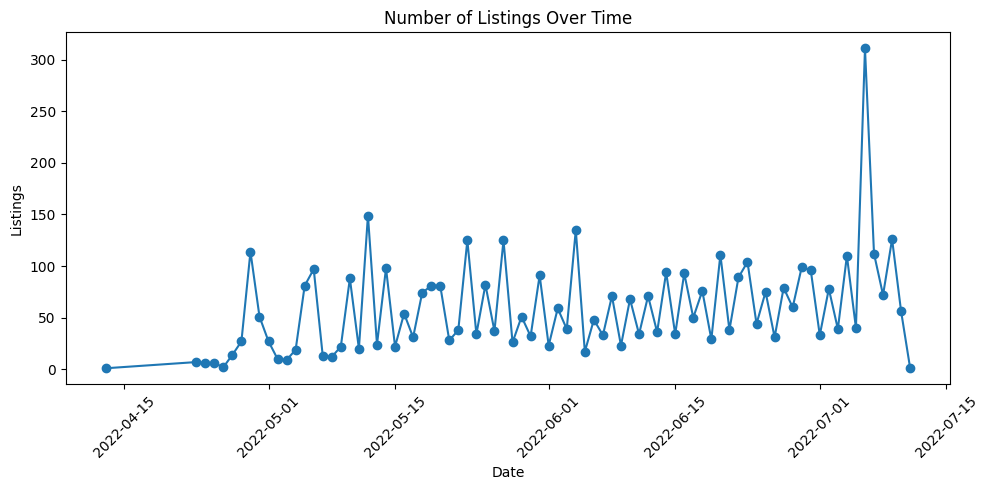

In [64]:
# Listing per date
date_counts = df_raw.group_by('Posted On').len().sort('Posted On')

dates = date_counts.select('Posted On').to_series().to_list()
counts = date_counts.select('len').to_series().to_list()

plt.figure(figsize=(10, 5))
plt.plot(dates, counts, marker='o')
plt.title('Number of Listings Over Time')
plt.xlabel('Date')
plt.ylabel('Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

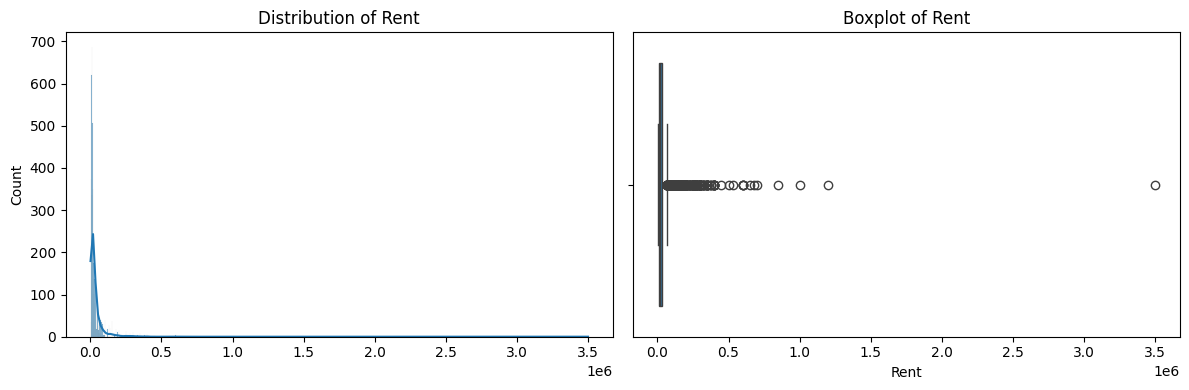

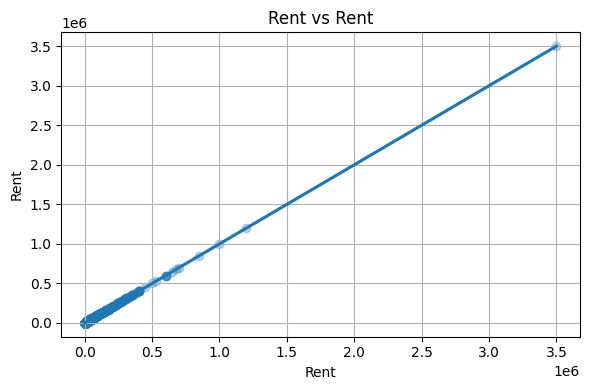

 Correlation between Rent and Rent: 1.00


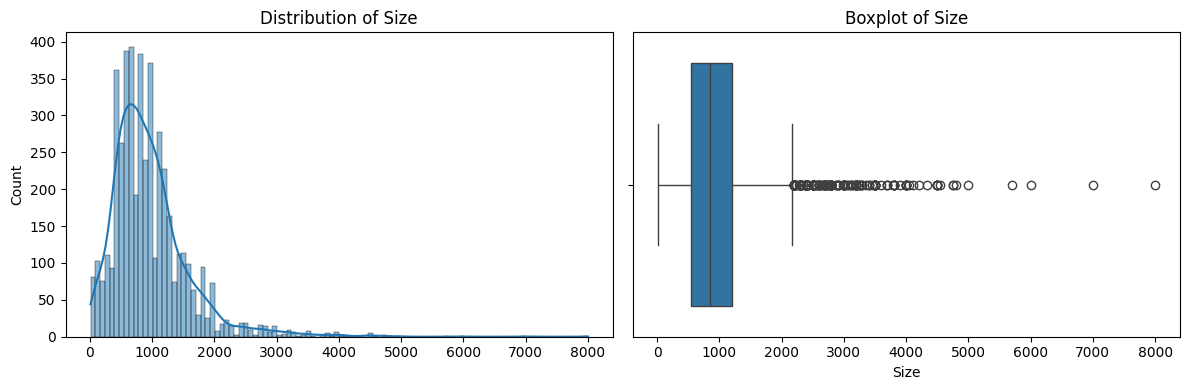

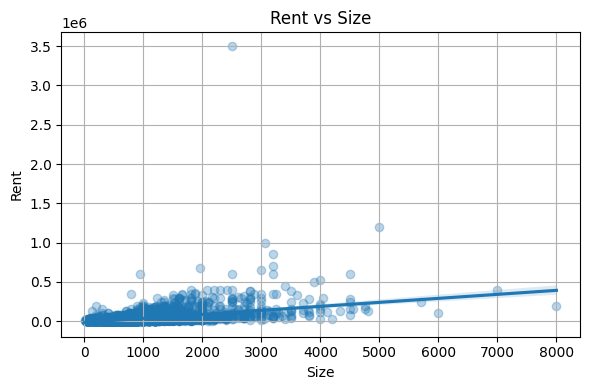

 Correlation between Size and Rent: 0.41


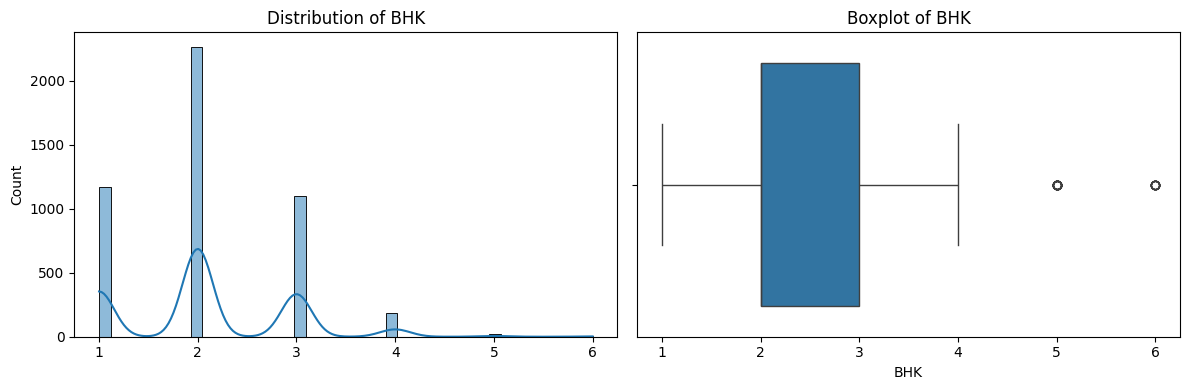

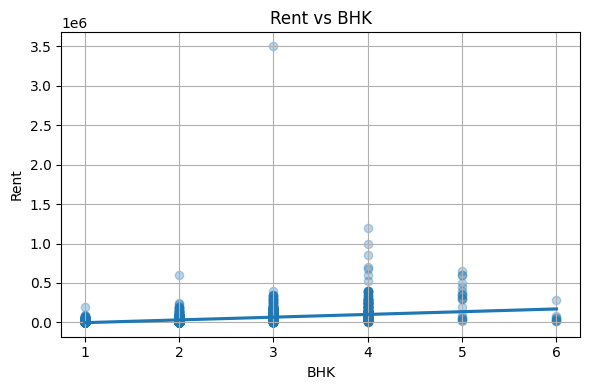

 Correlation between BHK and Rent: 0.37


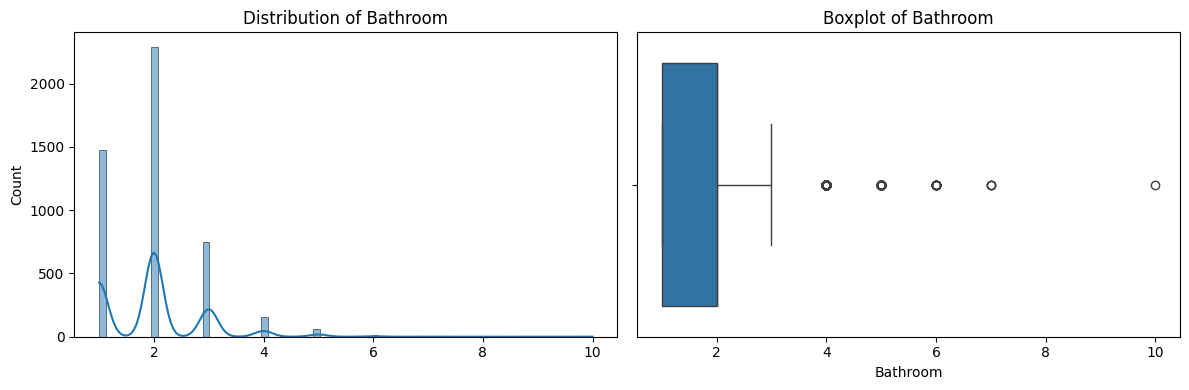

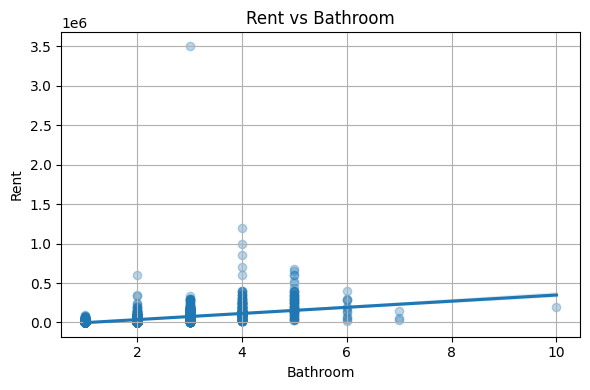

 Correlation between Bathroom and Rent: 0.44


In [65]:
# Numerical columns exploration
numerical_cols = ['Rent', 'Size', 'BHK', 'Bathroom']
numerical_cols_plot(df_raw, numerical_cols)


 Summary for Area Type:
shape: (3, 3)
┌─────────────┬───────────┬──────────────┐
│ Area Type   ┆ Frequency ┆ Avg_rent     │
│ ---         ┆ ---       ┆ ---          │
│ str         ┆ u32       ┆ f64          │
╞═════════════╪═══════════╪══════════════╡
│ Super Area  ┆ 2446      ┆ 18673.396566 │
│ Carpet Area ┆ 2298      ┆ 52385.897302 │
│ Built Area  ┆ 2         ┆ 10500.0      │
└─────────────┴───────────┴──────────────┘


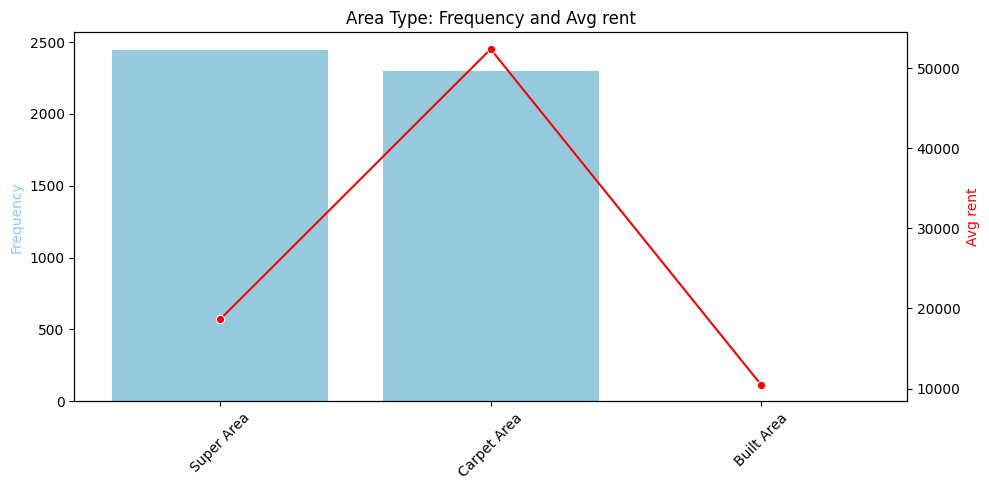


 Summary for Area Locality:
shape: (2_235, 3)
┌─────────────────────────────────┬───────────┬───────────────┐
│ Area Locality                   ┆ Frequency ┆ Avg_rent      │
│ ---                             ┆ ---       ┆ ---           │
│ str                             ┆ u32       ┆ f64           │
╞═════════════════════════════════╪═══════════╪═══════════════╡
│ Bandra West                     ┆ 37        ┆ 178918.918919 │
│ Gachibowli                      ┆ 29        ┆ 43879.310345  │
│ Electronic City                 ┆ 24        ┆ 13507.541667  │
│ Velachery                       ┆ 22        ┆ 16772.727273  │
│ Miyapur, NH 9                   ┆ 22        ┆ 17977.272727  │
│ …                               ┆ …         ┆ …             │
│ Hegganahalli                    ┆ 1         ┆ 10000.0       │
│ Garden View Apartment, Aarey M… ┆ 1         ┆ 18000.0       │
│ Pazhavanthangal, Jawaharlal Ne… ┆ 1         ┆ 7000.0        │
│ Venkateshappa Layout-Kammanaha… ┆ 1         ┆ 20000.0  

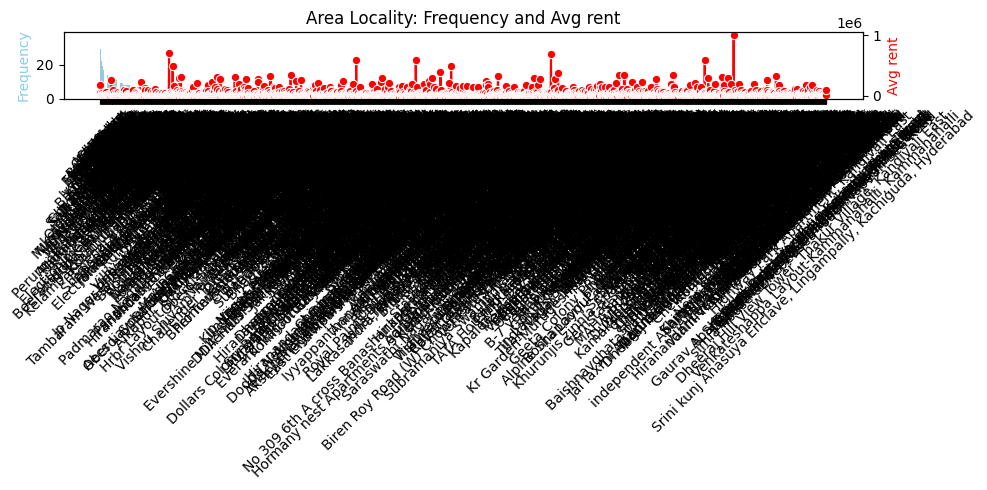


 Summary for City:
shape: (6, 3)
┌───────────┬───────────┬──────────────┐
│ City      ┆ Frequency ┆ Avg_rent     │
│ ---       ┆ ---       ┆ ---          │
│ str       ┆ u32       ┆ f64          │
╞═══════════╪═══════════╪══════════════╡
│ Mumbai    ┆ 972       ┆ 85321.204733 │
│ Chennai   ┆ 891       ┆ 21614.092031 │
│ Bangalore ┆ 886       ┆ 24966.365688 │
│ Hyderabad ┆ 868       ┆ 20555.048387 │
│ Delhi     ┆ 605       ┆ 29461.983471 │
│ Kolkata   ┆ 524       ┆ 11645.173664 │
└───────────┴───────────┴──────────────┘


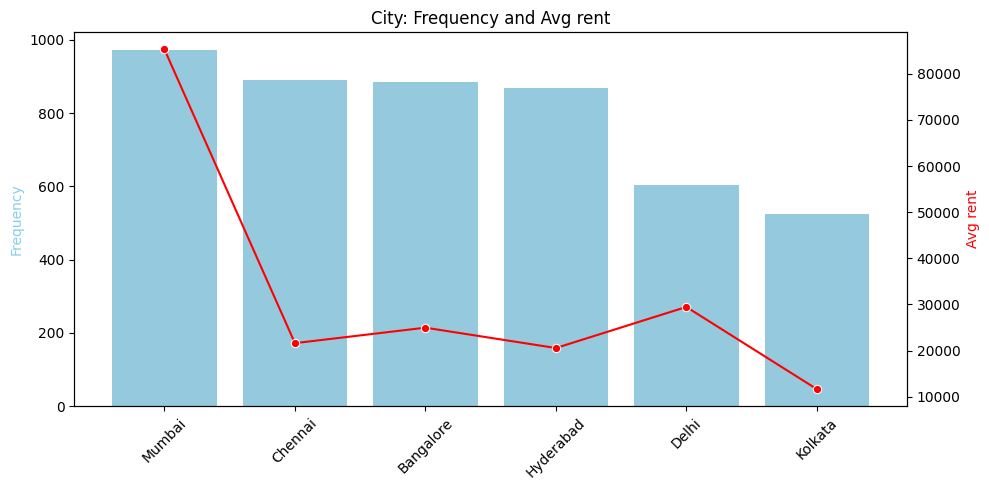


 Summary for Furnishing Status:
shape: (3, 3)
┌───────────────────┬───────────┬──────────────┐
│ Furnishing Status ┆ Frequency ┆ Avg_rent     │
│ ---               ┆ ---       ┆ ---          │
│ str               ┆ u32       ┆ f64          │
╞═══════════════════╪═══════════╪══════════════╡
│ Semi-Furnished    ┆ 2251      ┆ 38718.810751 │
│ Unfurnished       ┆ 1815      ┆ 22461.635813 │
│ Furnished         ┆ 680       ┆ 56110.305882 │
└───────────────────┴───────────┴──────────────┘


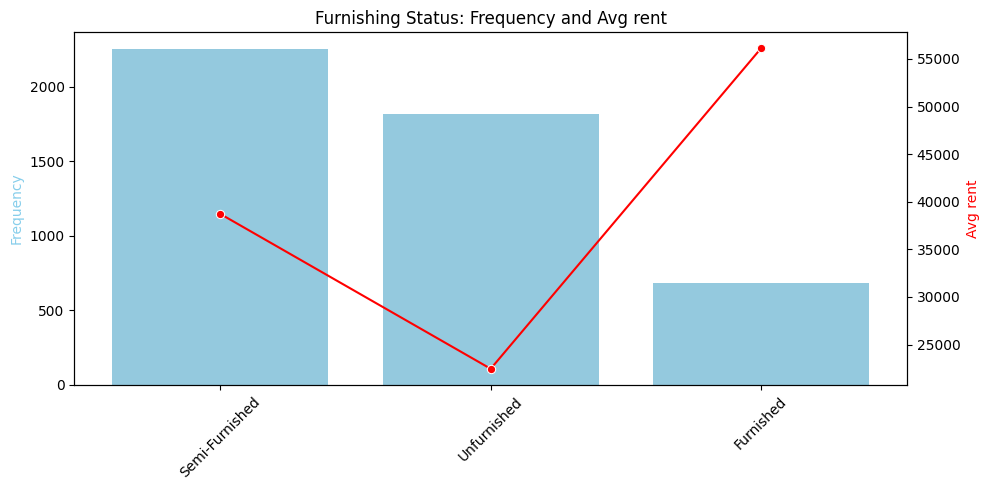


 Summary for Tenant Preferred:
shape: (3, 3)
┌──────────────────┬───────────┬──────────────┐
│ Tenant Preferred ┆ Frequency ┆ Avg_rent     │
│ ---              ┆ ---       ┆ ---          │
│ str              ┆ u32       ┆ f64          │
╞══════════════════╪═══════════╪══════════════╡
│ Bachelors/Family ┆ 3444      ┆ 31210.792683 │
│ Bachelors        ┆ 830       ┆ 42143.793976 │
│ Family           ┆ 472       ┆ 50020.341102 │
└──────────────────┴───────────┴──────────────┘


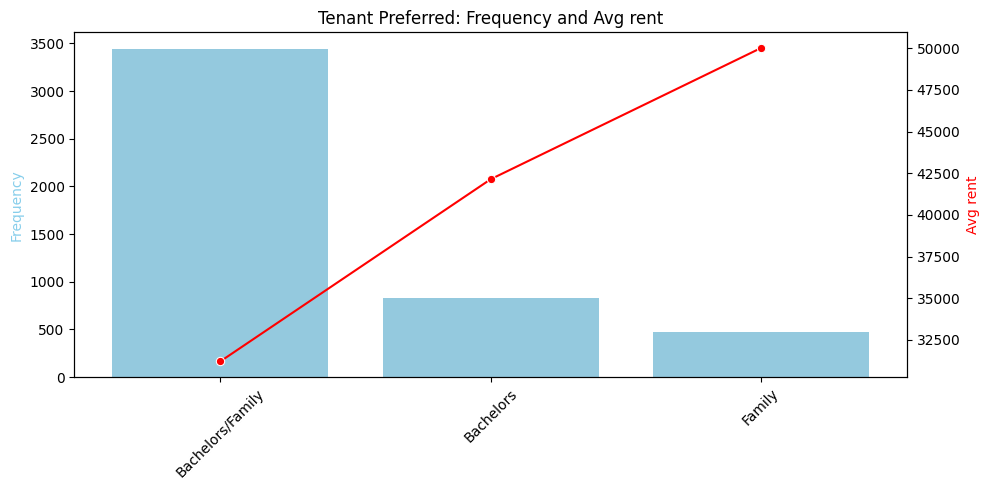


 Summary for Point of Contact:
shape: (3, 3)
┌──────────────────┬───────────┬──────────────┐
│ Point of Contact ┆ Frequency ┆ Avg_rent     │
│ ---              ┆ ---       ┆ ---          │
│ str              ┆ u32       ┆ f64          │
╞══════════════════╪═══════════╪══════════════╡
│ Contact Owner    ┆ 3216      ┆ 16704.206468 │
│ Contact Agent    ┆ 1529      ┆ 73481.158927 │
│ Contact Builder  ┆ 1         ┆ 5500.0       │
└──────────────────┴───────────┴──────────────┘


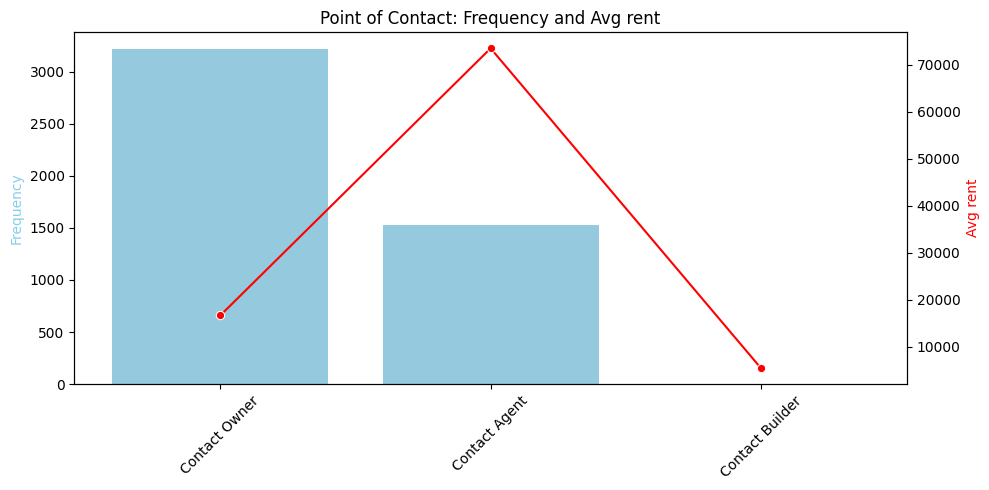


 Summary for Floor:
shape: (480, 3)
┌─────────────────┬───────────┬──────────────┐
│ Floor           ┆ Frequency ┆ Avg_rent     │
│ ---             ┆ ---       ┆ ---          │
│ str             ┆ u32       ┆ f64          │
╞═════════════════╪═══════════╪══════════════╡
│ 1 out of 2      ┆ 379       ┆ 14446.701847 │
│ Ground out of 2 ┆ 350       ┆ 14152.82     │
│ 2 out of 3      ┆ 312       ┆ 17333.974359 │
│ 2 out of 4      ┆ 308       ┆ 25464.272727 │
│ 1 out of 3      ┆ 293       ┆ 17954.607509 │
│ …               ┆ …         ┆ …            │
│ 4 out of 58     ┆ 1         ┆ 190000.0     │
│ 32 out of 59    ┆ 1         ┆ 150000.0     │
│ 25 out of 28    ┆ 1         ┆ 65000.0      │
│ 14 out of 68    ┆ 1         ┆ 98000.0      │
│ 35 out of 68    ┆ 1         ┆ 98000.0      │
└─────────────────┴───────────┴──────────────┘


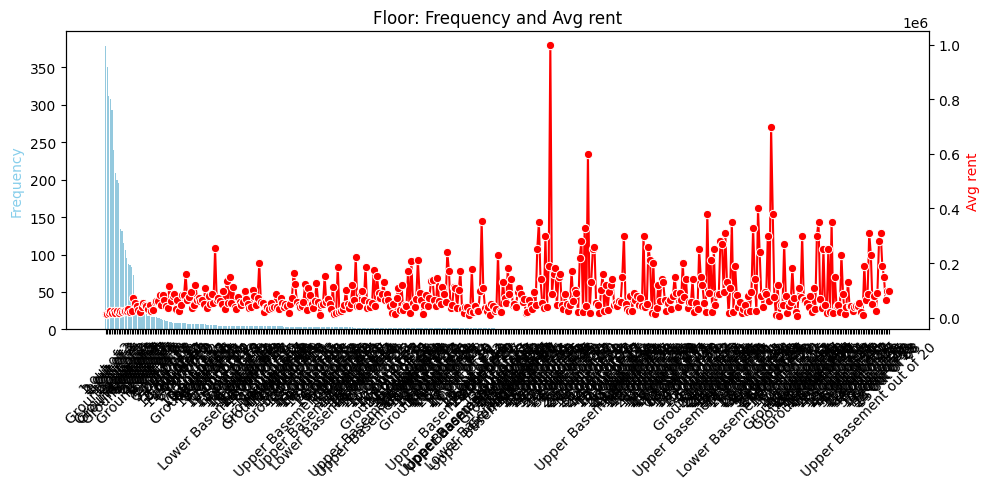


 Summary for Floor Group:
shape: (3, 3)
┌───────────────────────┬───────────┬──────────────┐
│ Floor Group           ┆ Frequency ┆ Avg_rent     │
│ ---                   ┆ ---       ┆ ---          │
│ str                   ┆ u32       ┆ f64          │
╞═══════════════════════╪═══════════╪══════════════╡
│ Lower Floor           ┆ 1983      ┆ 35981.132627 │
│ Upper Floor           ┆ 1802      ┆ 42710.690344 │
│ Ground Floor/Basement ┆ 961       ┆ 18484.568158 │
└───────────────────────┴───────────┴──────────────┘


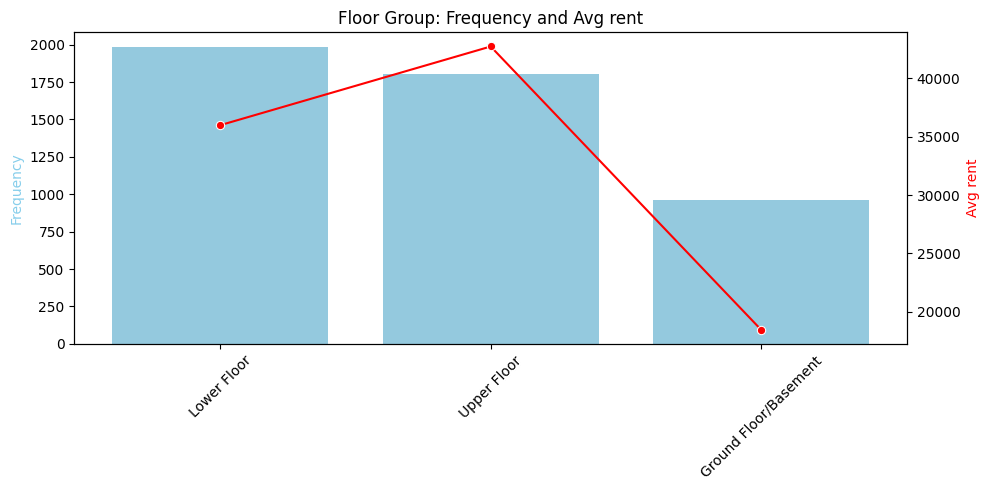


 Summary for BHK:
shape: (6, 3)
┌─────┬───────────┬───────────────┐
│ BHK ┆ Frequency ┆ Avg_rent      │
│ --- ┆ ---       ┆ ---           │
│ i64 ┆ u32       ┆ f64           │
╞═════╪═══════════╪═══════════════╡
│ 2   ┆ 2265      ┆ 22113.864018  │
│ 1   ┆ 1167      ┆ 14139.22365   │
│ 3   ┆ 1098      ┆ 55863.062842  │
│ 4   ┆ 189       ┆ 168864.555556 │
│ 5   ┆ 19        ┆ 297500.0      │
│ 6   ┆ 8         ┆ 73125.0       │
└─────┴───────────┴───────────────┘


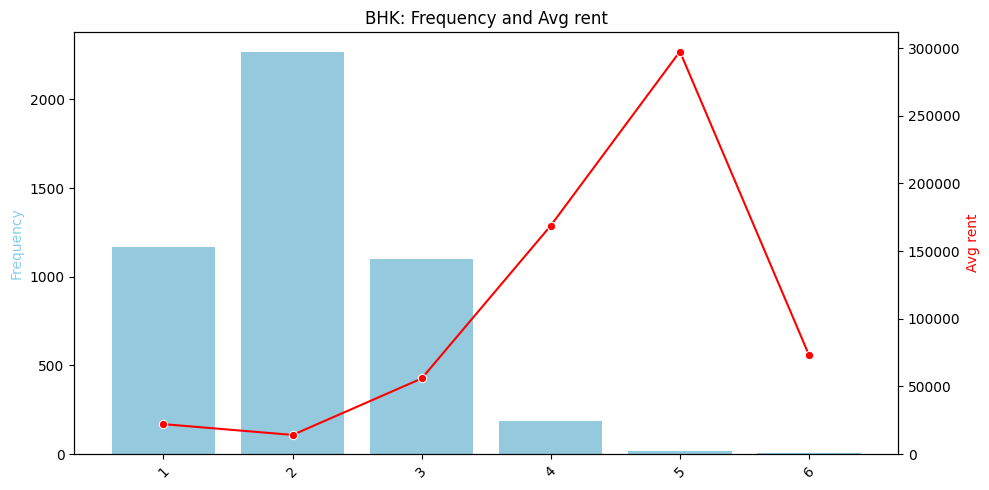


 Summary for Bathroom:
shape: (8, 3)
┌──────────┬───────────┬───────────────┐
│ Bathroom ┆ Frequency ┆ Avg_rent      │
│ ---      ┆ ---       ┆ ---           │
│ i64      ┆ u32       ┆ f64           │
╞══════════╪═══════════╪═══════════════╡
│ 2        ┆ 2291      ┆ 25043.538193  │
│ 1        ┆ 1474      ┆ 11862.162144  │
│ 3        ┆ 749       ┆ 63176.698264  │
│ 4        ┆ 156       ┆ 167846.153846 │
│ 5        ┆ 60        ┆ 252350.0      │
│ 6        ┆ 12        ┆ 177500.0      │
│ 7        ┆ 3         ┆ 81666.666667  │
│ 10       ┆ 1         ┆ 200000.0      │
└──────────┴───────────┴───────────────┘


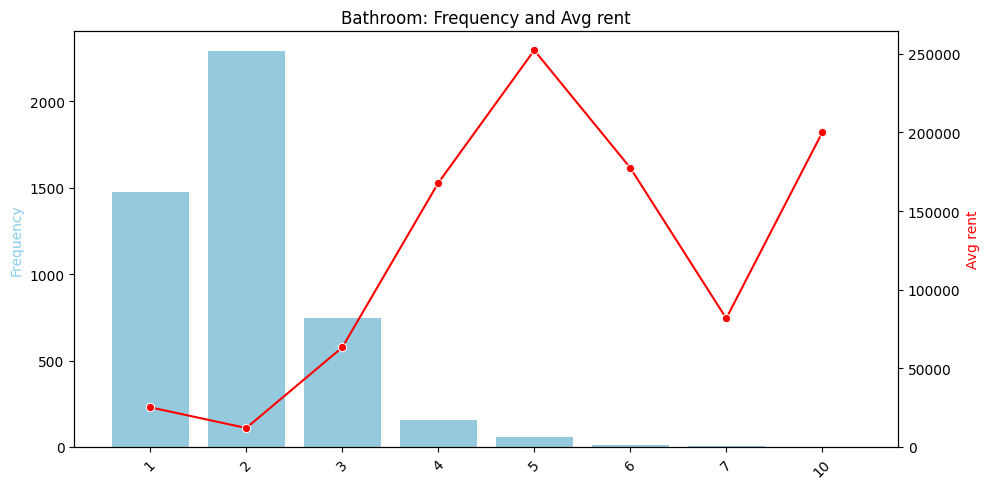

In [66]:
# Categorical columns exploration (BHK and Bathroom are also included here due them being discrete)
categorical_cols = [
    'Area Type',
    'Area Locality',
    'City',
    'Furnishing Status',
    'Tenant Preferred',
    'Point of Contact',
    'Floor',
    'Floor Group',
    'BHK',
    'Bathroom',
]
categorical_cols_plot(df_raw, categorical_cols)

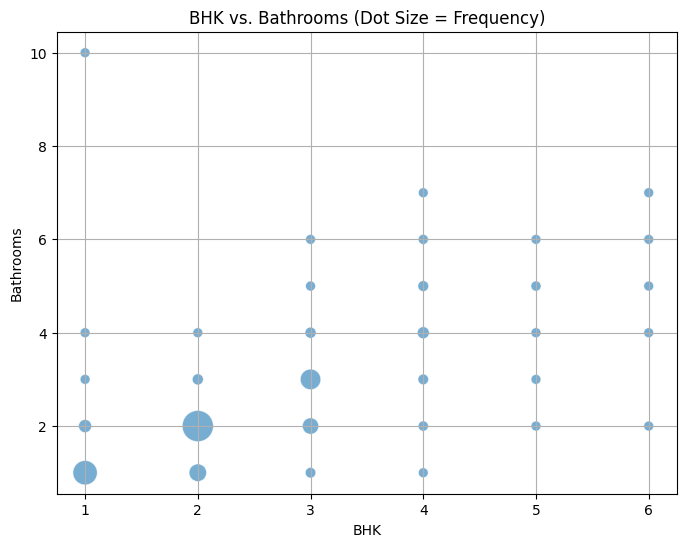

BHK,1,2,3,4,5,6,7,10
i64,u32,u32,u32,u32,u32,u32,u32,u32
1,1014,149,2,1,null,null,null,1
2,429,1781,53,2,null,null,null,null
3,30,345,662,54,6,1,null,null
4,1,13,31,95,40,8,1,null
5,null,2,1,3,12,1,null,null
6,null,1,null,1,2,2,2,null


In [67]:
# Checking dependency between BHK and Bathroom
df_pivot = bhk_vs_bathrooms(df_raw)
df_pivot

In [68]:
# Check each variable vs objetive (y)

After this brief analysis some conclusions can be made:
- Data time interval goes from Apr 15th 2022 to Jul 15th 2022. For this project date won't be considered.
- Area measure criteria is not unique for the full dataset (can be either Super Area or Carpet Area or Build Area)
- Area locality field have address specific data thus will not be considered for analysis.
- Point of contact have only one ocurrence of 'Contact Builder'
- Floor data was grouped as the original field was composed of a high count of unique values.
- Seems to be some inconsitency comparing Bathrooms vs BHK (too many bathrooms for too few rooms)


## Outlier Removal

Due to the data quantity being limited, the outlier process will drop a max of 5% of total datapoints (Up to 237 datapoint could be removed)

First criteria considered to remove data points:
- BHK greater than 4
- Bathroom greater than 5
- Size greater than 4000
- Rent greater than 500.000
- Bathroom greater than BHK + 1
- Point of Contact is not 'Contact Builder'

In [69]:
df_clean = df_raw.filter(
    (pl.col('BHK') <= 4)
    & (pl.col('Bathroom') <= 5)
    & (pl.col('Size') <= 3000)
    & (pl.col('Rent') <= 150000)
    & (pl.col('Bathroom') <= pl.col('BHK') + 1)
    & (pl.col('Point of Contact') != 'Contact Builder')
).drop(['Posted On', 'Area Locality', 'Floor', 'Area Type'])

print(
    f'Removed {df_raw.height - df_clean.height} out of {df_raw.height} datapoints.',
    f'\nCleaned dataset size: {df_clean.height}\n% of datapoints removed: {100 * (df_raw.height - df_clean.height) / df_raw.height:.2f}%',
)

Removed 221 out of 4746 datapoints. 
Cleaned dataset size: 4525
% of datapoints removed: 4.66%


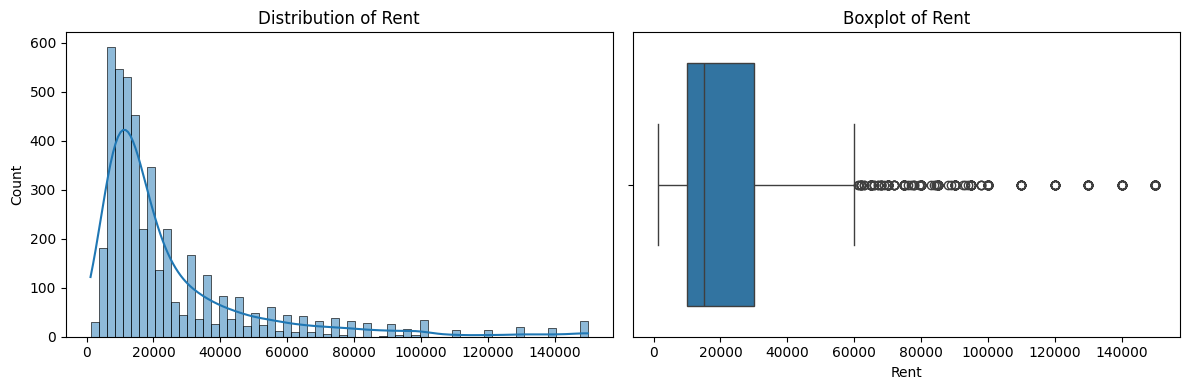

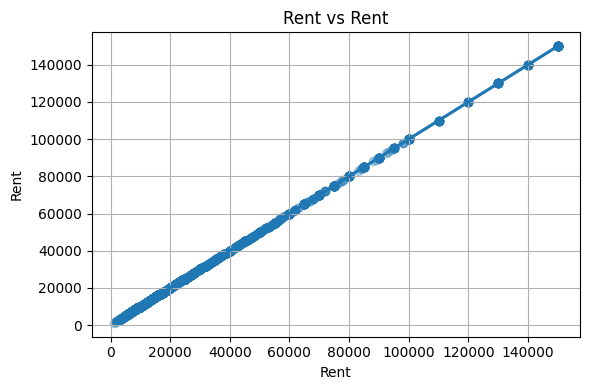

 Correlation between Rent and Rent: 1.00


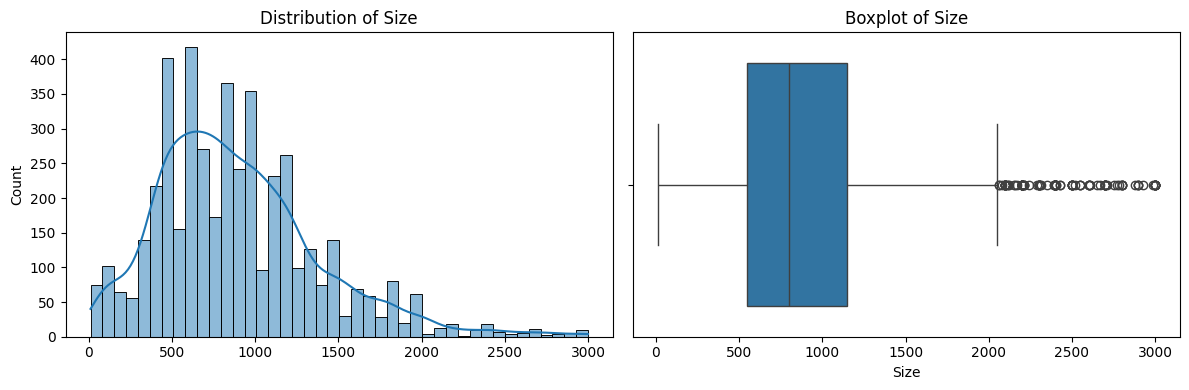

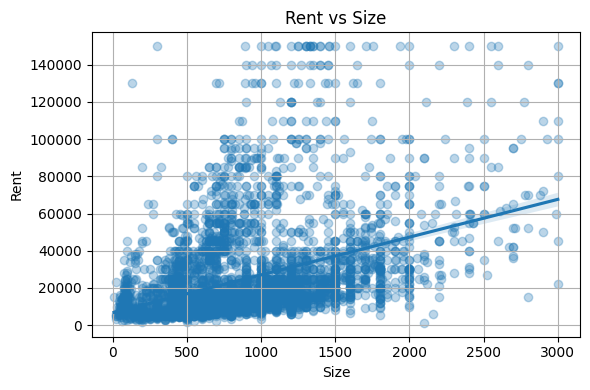

 Correlation between Size and Rent: 0.39


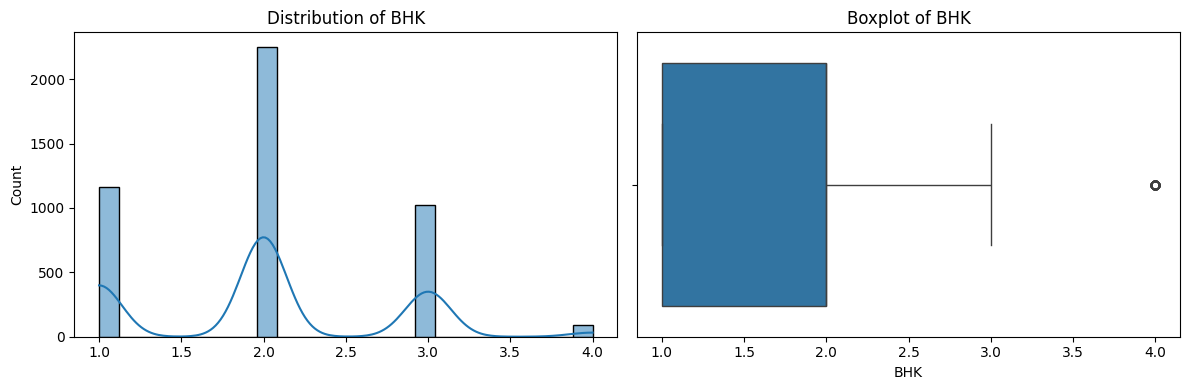

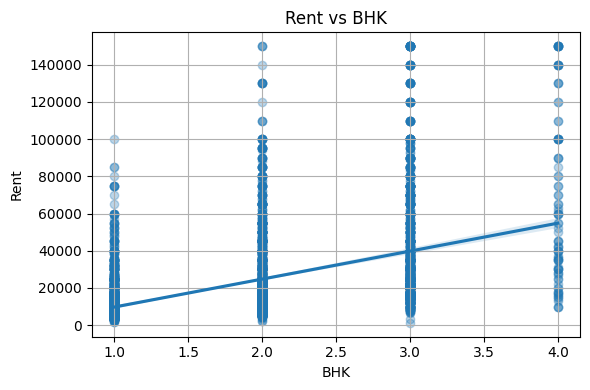

 Correlation between BHK and Rent: 0.44


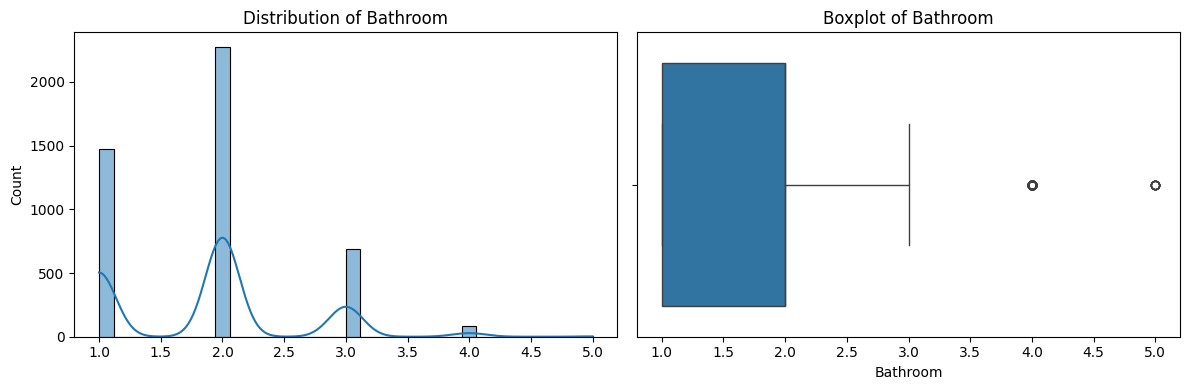

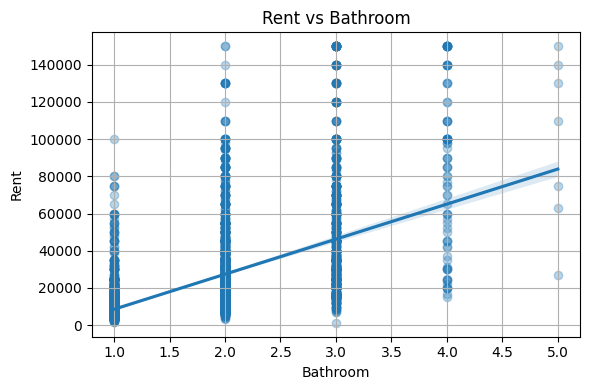

 Correlation between Bathroom and Rent: 0.55


In [70]:
numerical_cols = ['Rent', 'Size', 'BHK', 'Bathroom']
numerical_cols_plot(df_clean, numerical_cols)


 Summary for City:
shape: (6, 3)
┌───────────┬───────────┬──────────────┐
│ City      ┆ Frequency ┆ Avg_rent     │
│ ---       ┆ ---       ┆ ---          │
│ str       ┆ u32       ┆ f64          │
╞═══════════╪═══════════╪══════════════╡
│ Chennai   ┆ 874       ┆ 18693.542334 │
│ Bangalore ┆ 867       ┆ 18155.940023 │
│ Mumbai    ┆ 838       ┆ 54477.578759 │
│ Hyderabad ┆ 837       ┆ 17414.912784 │
│ Delhi     ┆ 592       ┆ 24551.52027  │
│ Kolkata   ┆ 517       ┆ 11092.01354  │
└───────────┴───────────┴──────────────┘


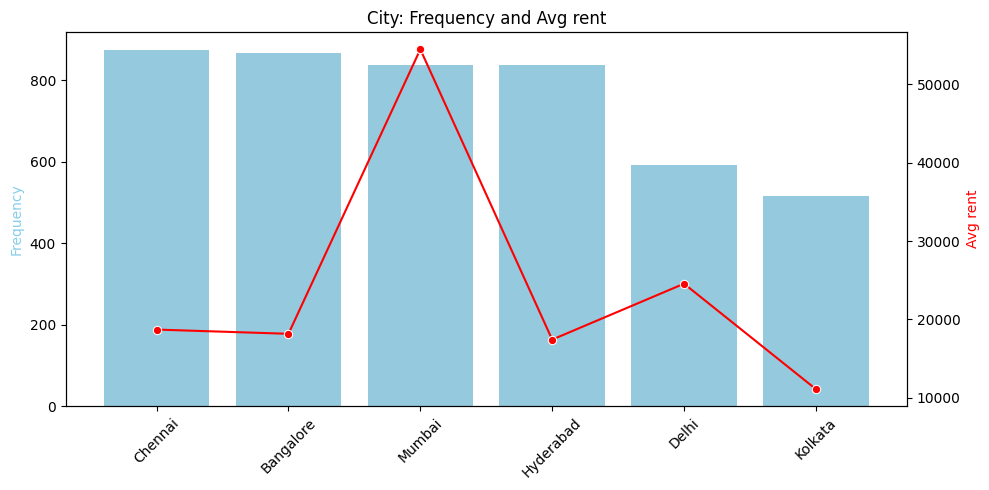


 Summary for Furnishing Status:
shape: (3, 3)
┌───────────────────┬───────────┬──────────────┐
│ Furnishing Status ┆ Frequency ┆ Avg_rent     │
│ ---               ┆ ---       ┆ ---          │
│ str               ┆ u32       ┆ f64          │
╞═══════════════════╪═══════════╪══════════════╡
│ Semi-Furnished    ┆ 2134      ┆ 26265.718369 │
│ Unfurnished       ┆ 1779      ┆ 19337.194491 │
│ Furnished         ┆ 612       ┆ 36151.973856 │
└───────────────────┴───────────┴──────────────┘


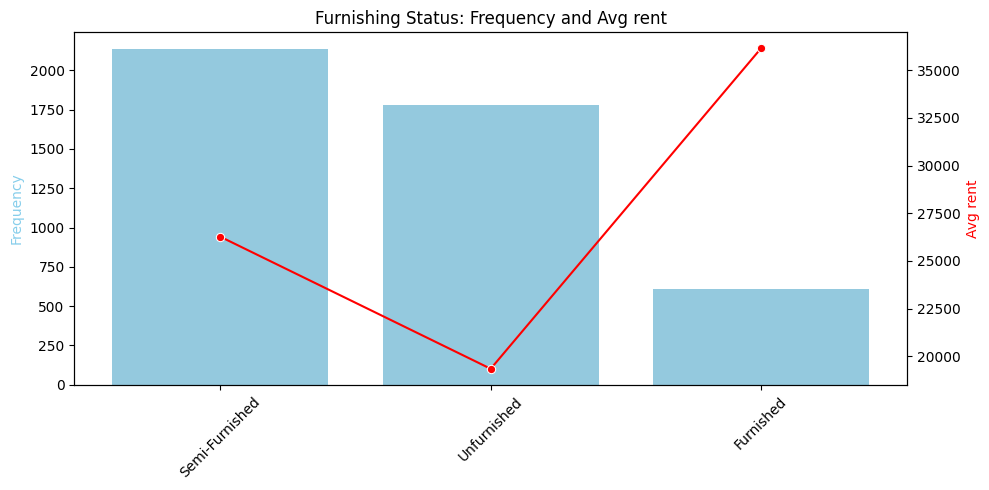


 Summary for Tenant Preferred:
shape: (3, 3)
┌──────────────────┬───────────┬──────────────┐
│ Tenant Preferred ┆ Frequency ┆ Avg_rent     │
│ ---              ┆ ---       ┆ ---          │
│ str              ┆ u32       ┆ f64          │
╞══════════════════╪═══════════╪══════════════╡
│ Bachelors/Family ┆ 3300      ┆ 22769.081818 │
│ Bachelors        ┆ 791       ┆ 28603.475348 │
│ Family           ┆ 434       ┆ 34132.721198 │
└──────────────────┴───────────┴──────────────┘


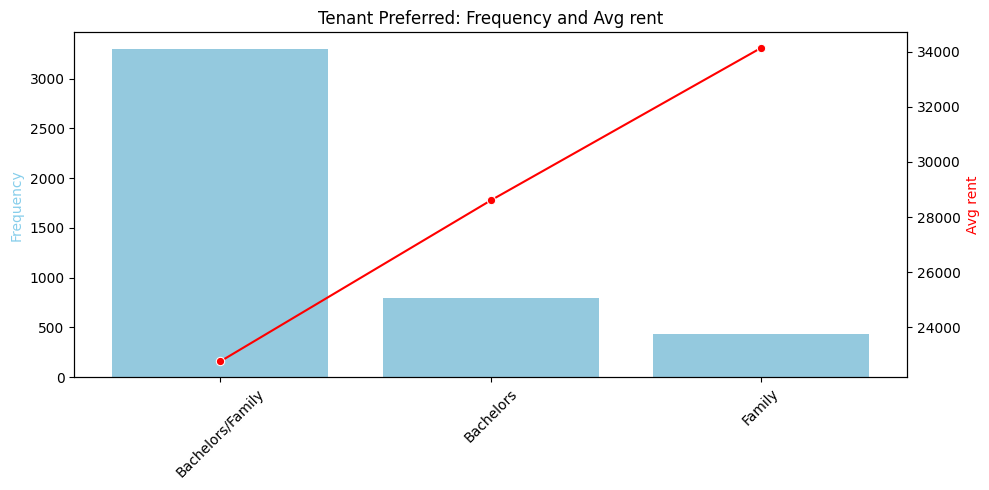


 Summary for Point of Contact:
shape: (2, 3)
┌──────────────────┬───────────┬──────────────┐
│ Point of Contact ┆ Frequency ┆ Avg_rent     │
│ ---              ┆ ---       ┆ ---          │
│ str              ┆ u32       ┆ f64          │
╞══════════════════╪═══════════╪══════════════╡
│ Contact Owner    ┆ 3179      ┆ 15429.452029 │
│ Contact Agent    ┆ 1346      ┆ 47196.650817 │
└──────────────────┴───────────┴──────────────┘


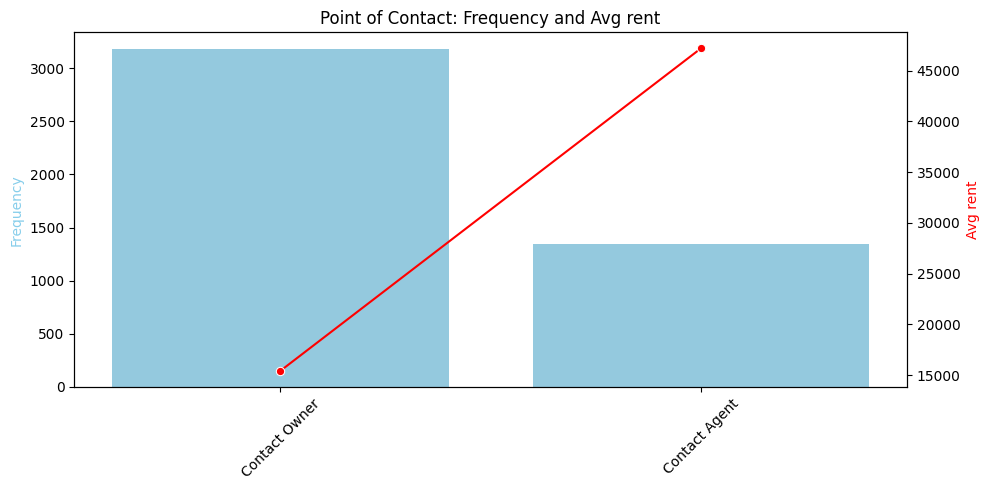


 Summary for Floor Group:
shape: (3, 3)
┌───────────────────────┬───────────┬──────────────┐
│ Floor Group           ┆ Frequency ┆ Avg_rent     │
│ ---                   ┆ ---       ┆ ---          │
│ str                   ┆ u32       ┆ f64          │
╞═══════════════════════╪═══════════╪══════════════╡
│ Lower Floor           ┆ 1904      ┆ 26597.209034 │
│ Upper Floor           ┆ 1687      ┆ 28328.787196 │
│ Ground Floor/Basement ┆ 934       ┆ 15144.721627 │
└───────────────────────┴───────────┴──────────────┘


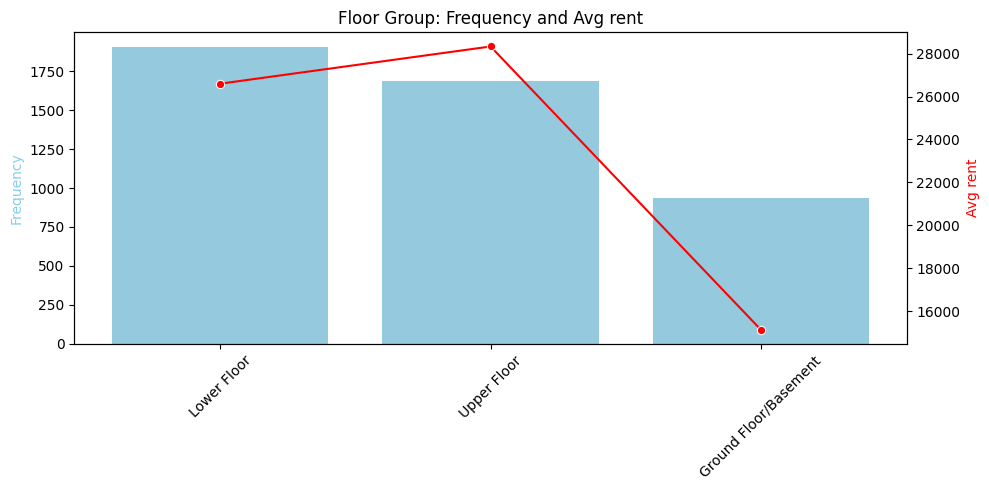


 Summary for BHK:
shape: (4, 3)
┌─────┬───────────┬──────────────┐
│ BHK ┆ Frequency ┆ Avg_rent     │
│ --- ┆ ---       ┆ ---          │
│ i64 ┆ u32       ┆ f64          │
╞═════╪═══════════╪══════════════╡
│ 2   ┆ 2251      ┆ 20949.756553 │
│ 1   ┆ 1162      ┆ 13938.015491 │
│ 3   ┆ 1019      ┆ 41983.947988 │
│ 4   ┆ 93        ┆ 69262.376344 │
└─────┴───────────┴──────────────┘


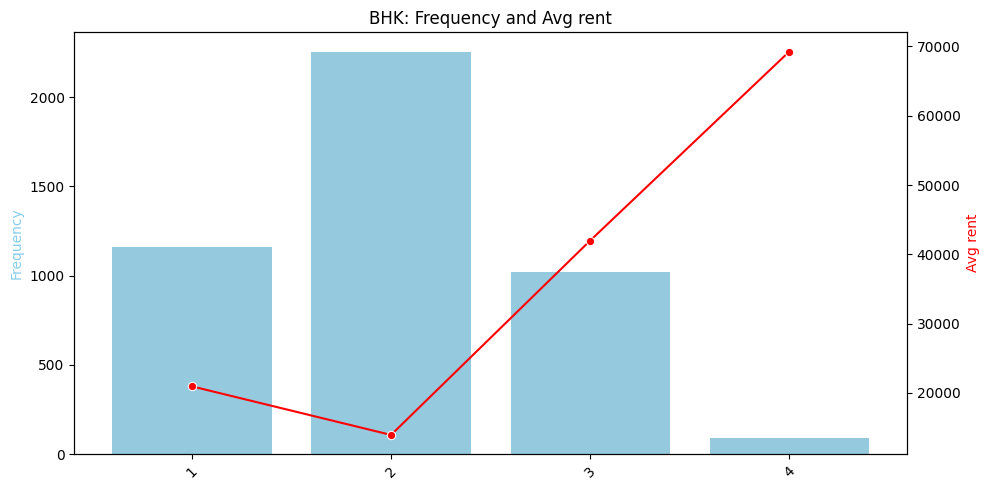


 Summary for Bathroom:
shape: (5, 3)
┌──────────┬───────────┬──────────────┐
│ Bathroom ┆ Frequency ┆ Avg_rent     │
│ ---      ┆ ---       ┆ ---          │
│ i64      ┆ u32       ┆ f64          │
╞══════════╪═══════════╪══════════════╡
│ 2        ┆ 2275      ┆ 23836.152088 │
│ 1        ┆ 1473      ┆ 11866.481331 │
│ 3        ┆ 688       ┆ 48387.132267 │
│ 4        ┆ 82        ┆ 83963.414634 │
│ 5        ┆ 7         ┆ 99285.714286 │
└──────────┴───────────┴──────────────┘


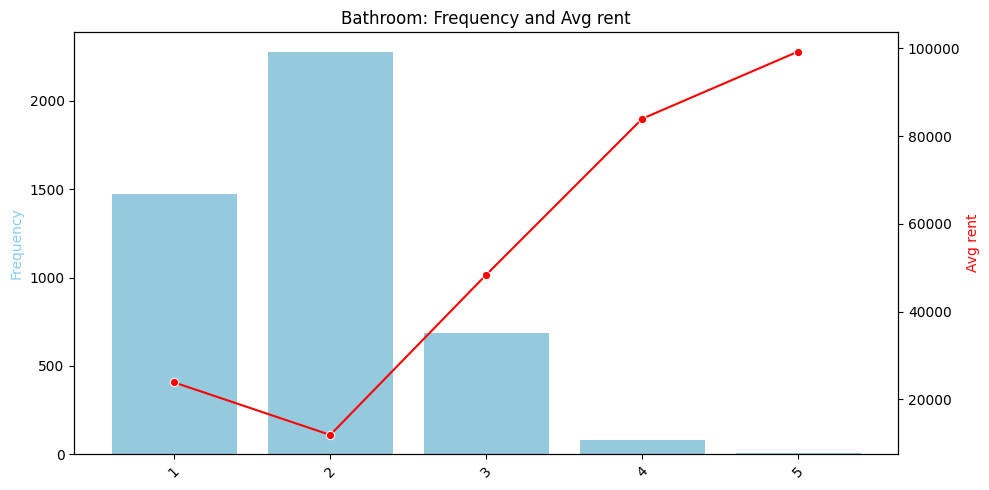

In [71]:
categorical_cols = [
    'City',
    'Furnishing Status',
    'Tenant Preferred',
    'Point of Contact',
    'Floor Group',
    'BHK',
    'Bathroom',
]
categorical_cols_plot(df_clean, categorical_cols)

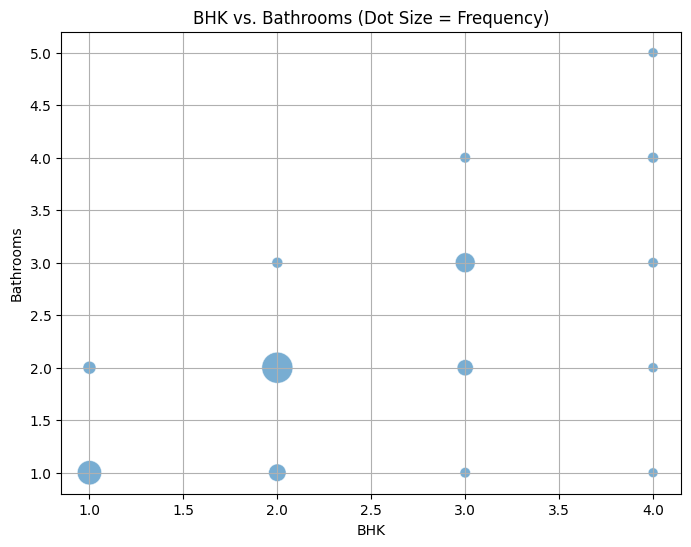

shape: (4, 6)
┌─────┬──────┬──────┬──────┬──────┬──────┐
│ BHK ┆ 1    ┆ 2    ┆ 3    ┆ 4    ┆ 5    │
│ --- ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ ---  │
│ i64 ┆ u32  ┆ u32  ┆ u32  ┆ u32  ┆ u32  │
╞═════╪══════╪══════╪══════╪══════╪══════╡
│ 1   ┆ 1013 ┆ 149  ┆ null ┆ null ┆ null │
│ 2   ┆ 429  ┆ 1772 ┆ 50   ┆ null ┆ null │
│ 3   ┆ 30   ┆ 341  ┆ 614  ┆ 34   ┆ null │
│ 4   ┆ 1    ┆ 13   ┆ 24   ┆ 48   ┆ 7    │
└─────┴──────┴──────┴──────┴──────┴──────┘


In [72]:
# Checking dependency between BHK and Bathroom
df_pivot = bhk_vs_bathrooms(df_clean)
print(df_pivot)

### ML Model Training

In [ ]:
import mlflow
from mlflow.models import infer_signature
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

target_col = 'Rent'
feature_cols = [col for col in df_clean.columns if col != target_col]
numeric_cols = ['Size', 'BHK', 'Bathroom']
categorical_cols = [col for col in feature_cols if col not in numeric_cols]
print(f'Feature columns: {feature_cols}')

X = df_clean.select(feature_cols).to_pandas()
y = df_clean.select(target_col).to_numpy().flatten()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature columns: ['BHK', 'Size', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact', 'Floor Group']


In [ ]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

models = {
    'Linear Regression': Pipeline([
        ('preprocess', preprocessor),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('preprocess', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocess', preprocessor),
        ('model', XGBRegressor(random_state=42))
    ]),
    'LightGBM': Pipeline([
        ('preprocess', preprocessor),
        ('model', LGBMRegressor(random_state=42))
    ]),
}

results = []
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)


    # Load all models to MLflow
    with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(pipeline.get_params())

        # Log the loss metric
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", name)

        # Infer the model signature
        signature = infer_signature(X_train, preds)

        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path=name.lower().replace(" ", "_"),
            signature=signature,
            input_example=X_train.sample(n=5, random_state=42),
            registered_model_name=name,
        )


c:\Users\nicoj\OneDrive\Documents\Facultad\Master Big Data\99 - TFM\rent-price-model\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Linear Regression'.
2025/05/25 18:15:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creat

🏃 View run amusing-seal-853 at: http://127.0.0.1:8080/#/experiments/0/runs/60c89b911bff405088d1c3177bcfa5a3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


c:\Users\nicoj\OneDrive\Documents\Facultad\Master Big Data\99 - TFM\rent-price-model\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Random Forest'.
2025/05/25 18:15:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation.

🏃 View run languid-lamb-944 at: http://127.0.0.1:8080/#/experiments/0/runs/f6fced3eb6914434b0e2eb005635beac
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


c:\Users\nicoj\OneDrive\Documents\Facultad\Master Big Data\99 - TFM\rent-price-model\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'XGBoost'.
2025/05/25 18:15:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model

🏃 View run adaptable-deer-485 at: http://127.0.0.1:8080/#/experiments/0/runs/ba3f175189084bf4a132f2d6851649c5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 3620, number of used features: 20
[LightGBM] [Info] Start training from score 24900.427348


c:\Users\nicoj\OneDrive\Documents\Facultad\Master Big Data\99 - TFM\rent-price-model\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\nicoj\OneDrive\Documents\Facultad\Master Big Data\99 - TFM\rent-price-model\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid f

🏃 View run nimble-dog-589 at: http://127.0.0.1:8080/#/experiments/0/runs/26c536096b1e44c2aa32c6687024ddd6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0

📊 Model Comparison:
Model                RMSE       MAE       
----------------------------------------
Linear Regression    15169.77   9647.74   
Random Forest        13971.12   7642.94   
XGBoost              14482.01   7855.28   
LightGBM             13942.20   7523.17   


Created version '1' of model 'LightGBM'.


In [ ]:
"""from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ----------------------------

target_col = 'Rent'
feature_cols = [col for col in df_clean.columns if col != target_col]

# Define numerical and categorical columns
numeric_cols = ['Size', 'BHK', 'Bathroom']  # Update as needed
categorical_cols = [col for col in feature_cols if col not in numeric_cols]

X = df_clean.select(feature_cols).to_pandas()
y = df_clean.select(target_col).to_numpy().flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


# ----------------------------
# 2️⃣ Preprocessing Pipelines
# ----------------------------
preprocessor_linear = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

preprocessor_tree = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # No scaling
])

# ----------------------------
# 3️⃣ Models Definition
# ----------------------------
models = {
    'Linear Regression': Pipeline([
        ('preprocess', preprocessor_linear),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('preprocess', preprocessor_tree),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'XGBoost': XGBRegressor(
        random_state=42, 
        early_stopping_rounds=10, 
        eval_metric='rmse',
        enable_categorical=True
    ),
    'LightGBM': LGBMRegressor(
        random_state=42, 
        early_stopping_rounds=10,
        enable_categorical=True
    ),
}

# ----------------------------
# 4️⃣ Train, Predict, Evaluate
# ----------------------------
results = []

for name, model in models.items():
    if name in ['XGBoost', 'LightGBM']:
        # Boosting models handle categoricals better with raw data
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        preds = model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append((name, rmse, mae, r2))

# ----------------------------
# 5️⃣ Results Display
# ----------------------------
print('\n📊 Model Comparison:')
print(f'{'Model':<20} {'RMSE':<10} {'MAE':<10} {'R²':<10}')
print('-' * 50)
for model_name, rmse_val, mae_val, r2_val in results:
    print(f'{model_name:<20} {rmse_val:<10.2f} {mae_val:<10.2f} {r2_val:<10.2f}')
"""

[0]	validation_0-rmse:19709.41409
[1]	validation_0-rmse:16561.10690
[2]	validation_0-rmse:14961.31209
[3]	validation_0-rmse:14161.36527
[4]	validation_0-rmse:13664.95231
[5]	validation_0-rmse:13469.91130
[6]	validation_0-rmse:13435.18118
[7]	validation_0-rmse:13417.74084
[8]	validation_0-rmse:13515.83283
[9]	validation_0-rmse:13530.82735
[10]	validation_0-rmse:13459.13759
[11]	validation_0-rmse:13435.52586
[12]	validation_0-rmse:13463.10881
[13]	validation_0-rmse:13437.45956
[14]	validation_0-rmse:13415.82981
[15]	validation_0-rmse:13390.62641
[16]	validation_0-rmse:13408.21011
[17]	validation_0-rmse:13405.02045
[18]	validation_0-rmse:13425.73202
[19]	validation_0-rmse:13448.17199
[20]	validation_0-rmse:13492.45237
[21]	validation_0-rmse:13537.67315
[22]	validation_0-rmse:13553.07808
[23]	validation_0-rmse:13608.28332
[24]	validation_0-rmse:13605.43438
[25]	validation_0-rmse:13659.64156
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] early_stopping_round